### Installing packages and downloading datasets/weights

In [217]:
# !apt install libsparsehash-dev
%pip install -q opencv-python imageio
# %pip install pytorch>=1.6.0 torchvision>=0.7.0 cudatoolkit>=10.2
# %pip install --upgrade git+https://github.com/mit-han-lab/torchsparse.git@v1.2.0

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [318]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0002/2011_09_26_drive_0002_sync.zip -O 2011_09_26_drive_0002_sync.zip
!unzip -qn 2011_09_26_drive_0002_sync.zip
!mv ./2011_09_26/2011_09_26_drive_0002_sync ./

!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip -O 2011_09_26_calib.zip
!unzip -qn 2011_09_26_calib.zip
!mv ./2011_09_26/calib* ./projection/default_calibration

!rm -rf ./2011_09_26
!rm -rf 2011_09_26_drive_0002_sync.zip 2011_09_26_calib.zip

In [310]:
!wget https://cloudstor.aarnet.edu.au/plus/s/lTIJF4vrvHCAI31/download -O depth_prediction/res101.pth
# !wget https://cloudstor.aarnet.edu.au/plus/s/VVQayrMKPlpVkw9/download -O depth_prediction/res50.pth

--2022-07-11 10:46:25--  https://cloudstor.aarnet.edu.au/plus/s/lTIJF4vrvHCAI31/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=v022tv3n84c1jsrk5tcp4icbr2; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=UQ11kmZP6T4MScRaKxCy1tuU5Ou%2Fs%2FUJjO5%2FT0Q5e0LGYEMxONd782p%2FJcpZyv4%2FMg6EZiyKipFUP6jxcTOKWIidhKGMk9siWvog64fRPppZ%2B10WPgtQE3ddinm95nCh; expires=Tue, 12-Jul-2022 10:46:27 GMT; Max-Age=86400; path=/plus;; Secure at position 228.
Length: 530760553 (506M) [application/octet-stream]
Saving to: ‘depth_prediction/res101.pth’

depth_prediction/re 100%[===================>] 506.17M  8.93MB/s    in 63s     

2022-07-11 10:47:31 (8.03 MB/s) - ‘depth_prediction/res101.pth’ saved [530760553/530760553]



### Image transformation and visualization

In [324]:
import cv2
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image, ImageOps, ImageMath

In [340]:
#!g1.1:bash
export PYTHONPATH=./depth_prediction/
python3 ./depth_prediction/depth_predictor.py --load_ckpt ./depth_prediction/res101.pth --backbone resnext101 --input_path ./2011_09_26_drive_0002_sync/image_00/data/ --output_path ./processed/depth_00/ --no-verbose
python3 ./depth_prediction/depth_predictor.py --load_ckpt ./depth_prediction/res101.pth --backbone resnext101 --input_path ./2011_09_26_drive_0002_sync/image_01/data/ --output_path ./processed/depth_01/ --no-verbose
python3 ./depth_prediction/depth_predictor.py --load_ckpt ./depth_prediction/res101.pth --backbone resnext101 --input_path ./2011_09_26_drive_0002_sync/image_02/data/ --output_path ./processed/depth_02/ --no-verbose
python3 ./depth_prediction/depth_predictor.py --load_ckpt ./depth_prediction/res101.pth --backbone resnext101 --input_path ./2011_09_26_drive_0002_sync/image_03/data/ --output_path ./processed/depth_03/ --no-verbose

loading checkpoint ./depth_prediction/res101.pth
100%|███████████████████████████████████████████| 77/77 [00:11<00:00,  6.63it/s]
loading checkpoint ./depth_prediction/res101.pth
100%|███████████████████████████████████████████| 77/77 [00:11<00:00,  6.62it/s]
loading checkpoint ./depth_prediction/res101.pth
100%|███████████████████████████████████████████| 77/77 [00:11<00:00,  6.50it/s]
loading checkpoint ./depth_prediction/res101.pth
100%|███████████████████████████████████████████| 77/77 [00:12<00:00,  6.39it/s]


In [474]:
def parse_calibration(path):
    with open(path) as f:
        calib = f.readlines()
        
    res = dict()    
    for line in calib:
        xs = line.strip('\n').split()
        name = xs[0][:-1]
        if name == "calib_time":
            continue
        res[name] = np.array([float(x) for x in xs[1:]])
    
    return res

def extract_velo_to_cam_transform(path, cam_num=2):
    cam_to_cam = parse_calibration(os.path.join(path, "calib_cam_to_cam.txt"))
    P = cam_to_cam['P_rect_0' + str(cam_num)].reshape(3, 4)
    R0_rect = cam_to_cam['R_rect_00'].reshape(3, 3)
    
    # Add a 1 in bottom-right, reshape to 4 x 4
    R0_rect = np.insert(R0_rect, 3, values=[0,0,0], axis=0)
    R0_rect = np.insert(R0_rect, 3, values=[0,0,0,1], axis=1)
    
    velo_to_cam = parse_calibration(os.path.join(path, "calib_velo_to_cam.txt"))
    # matrix (R | T)
    Tr_velo_to_cam = np.hstack((velo_to_cam['R'].reshape(3, 3), velo_to_cam['T'].reshape(-1, 1)))
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)
    
    return {
        "P": P,
        "R0_rect": R0_rect,
        "Tr_velo_to_cam": Tr_velo_to_cam
    } 

def get_cam(path):
    cam = np.fromfile(path, dtype=np.float32).reshape((-1,4))
    cam = cam[:, 0:3] # lidar xyz (front, left, up)
    cam = np.insert(cam, 3, 1, axis=1).T
    cam = np.delete(cam, np.where(cam[0, :] < 0), axis=1)
    return cam

def transfrom_cam(cam, calib):
    cam = calib['P'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam'] @ cam
    cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)
    return cam

def get_img(path):
    img = mpimg.imread(path)
    if len(img.shape) < 3:
        img = np.repeat(img.reshape(img.shape[0], img.shape[1], 1), 3, -1)
    return img

def project_cam(cam, IMG_W, IMG_H, ret_raw=False):
    x, y, z = cam
    u, v = np.round(x / z), np.round(y / z)

    # filter point out of canvas
    u_in = np.logical_and(u >= 0, u < IMG_W)
    v_in = np.logical_and(v >= 0, v < IMG_H)
    cond = np.logical_and(u_in, v_in)
    if ret_raw:
        return cam[cond]
    return u[cond], v[cond], z[cond]
    
def draw_projection(img, cam, save_path=None, show=False):
    # generate color map from depth
    IMG_H, IMG_W, _ = img.shape
    u, v, d = project_cam(cam, IMG_W, IMG_H)

    plt.figure(figsize=(12,5), dpi=96, tight_layout=True)
    plt.imshow(img)
    plt.scatter([u], [v], c=[d], cmap='rainbow_r', alpha=0.5, s=2)
    plt.axis('off')
    plt.margins(x=0)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

### Projecion and GIFs

In [367]:
def project_lidar_on_images(images_path, result_path, cam_num=2):
    calibration_path = "./projection/default_calibration"
    lidar_path = "./2011_09_26_drive_0002_sync/velodyne_points/data/"
    calib = extract_velo_to_cam_transform(calibration_path, cam_num=cam_num)
    os.makedirs(result_path, exist_ok=True)
    
    for i in tqdm(range(77)):
        img_id = f"{i:010d}"

        img = get_img(os.path.join(images_path, img_id + ".png"))
        cam = get_cam(os.path.join(lidar_path, img_id + ".bin"))
        cam = transfrom_cam(cam, calib)

        draw_projection(img, cam, save_path=os.path.join(result_path, img_id + ".png"))

def generate_gif_with_images(images_path, result_path):
    frames = [Image.open(os.path.join(images_path, f"{i:010d}.png")) for i in range(77)]
    frames[0].save(result_path, format="GIF", append_images=frames[1:], save_all=True, duration=100, optimize=True, loop=0)

In [368]:
# project_lidar_on_images("./2011_09_26_drive_0002_sync/image_00/data/", "./processed/lidar_00", cam_num=0)
# project_lidar_on_images("./2011_09_26_drive_0002_sync/image_01/data/", "./processed/lidar_01", cam_num=1)
project_lidar_on_images("./2011_09_26_drive_0002_sync/image_02/data/", "./processed/lidar_02", cam_num=2)
# project_lidar_on_images("./2011_09_26_drive_0002_sync/image_03/data/", "./processed/lidar_03", cam_num=3)

# project_lidar_on_images("./processed/depth_00", "./processed/depth_lidar_00", cam_num=0)
# project_lidar_on_images("./processed/depth_01", "./processed/depth_lidar_01", cam_num=1)
project_lidar_on_images("./processed/depth_02", "./processed/depth_lidar_02", cam_num=2)
# project_lidar_on_images("./processed/depth_03", "./processed/depth_lidar_03", cam_num=3)

In [369]:
# generate_gif_with_images("./processed/depth_00", "./processed/depth_00.gif")
# generate_gif_with_images("./processed/depth_01", "./processed/depth_01.gif")
generate_gif_with_images("./processed/depth_02", "./processed/depth_02.gif")
# generate_gif_with_images("./processed/depth_03", "./processed/depth_03.gif")

# generate_gif_with_images("./processed/lidar_00", "./processed/lidar_00.gif")
# generate_gif_with_images("./processed/lidar_01", "./processed/lidar_01.gif")
generate_gif_with_images("./processed/lidar_02", "./processed/lidar_02.gif")
# generate_gif_with_images("./processed/lidar_03", "./processed/lidar_03.gif")

# generate_gif_with_images("./processed/depth_lidar_00", "./processed/depth_lidar_00.gif")
# generate_gif_with_images("./processed/depth_lidar_01", "./processed/depth_lidar_01.gif")
generate_gif_with_images("./processed/depth_lidar_02", "./processed/depth_lidar_02.gif")
# generate_gif_with_images("./processed/depth_lidar_03", "./processed/depth_lidar_03.gif")

### Scale Prediction

In [485]:
def cam_split(cam, strategy='left_half', params=dict()):
    u, v, z = project_cam(cam, params['IMG_W'], params['IMG_H'])
    u = np.round(u).astype(np.int)
    v = np.round(v).astype(np.int)
    cond = None
    if strategy == 'left_half':
        cond = u <= (params['IMG_W'] // 2)
    elif strategy == 'right_half':
        cond = u > (params['IMG_W'] // 2)
    elif strategy == 'rect':
        cond = (u <= params['R']) & (u >= params['L']) & (v >= params['D']) & (v <= params['U'])
    
    return (u[cond], v[cond], z[cond]), (u[~cond], v[~cond], z[~cond])

# def get_scale()

In [493]:
a = np.random.randint(0, 100, size=10)
b = np.random.randint(0, 100, size=10)
asort = a.argsort()
asort, a, a[asort], b, b[asort]

(array([6, 4, 3, 0, 7, 9, 5, 8, 1, 2]),
 array([35, 80, 98, 31, 20, 65, 14, 36, 72, 54]),
 array([14, 20, 31, 35, 36, 54, 65, 72, 80, 98]),
 array([29, 39, 20, 36,  6, 88, 28, 26, 54, 66]),
 array([28,  6, 36, 29, 26, 66, 88, 54, 39, 20]))

In [567]:
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression


class ScaleEstimator(BaseEstimator):
    def __init__(self, strategy='MSE', bias=True, eps=1e-8):
        self.strategy = strategy
        self.bias_req = bias
        self.scale = 1
        self.bias = 0
        self.eps = eps
    
    def fit(self, depth, cam):
        v, u, D = cam
        d = depth[u, v]
        d.shape
        if len(depth.shape) == 3:
            d = d[:, 0]
        d = d.reshape(-1, 1)
#         print(d.shape, D.shape)
            
        if self.strategy == "MSE":
            linreg = LinearRegression(fit_intercept=self.bias_req).fit(d, D)
            self.scale = linreg.coef_[0]
            self.bias = linreg.intercept_
            
        elif self.strategy == "MSLE":
            self.scale = np.exp(np.log(D + self.eps).mean() - np.log(d + self.eps).mean())
            
        elif self.strategy == "MAE":
            Dd = D / (d[:, 0] + self.eps)
            Ddsort = np.argsort(Dd)
            d_pref = 2 * np.cumsum(d[Ddsort, 0]) - d.sum()
            pos = np.searchsorted(d_pref, 0)
            self.scale = Dd[Ddsort[pos]]
    
        elif self.strategy == "MinMax":
            D_min, D_max, d_min, d_max = D.min(), D.max(), d.min(), d.max()
            self.scale = (D_max - D_min) / (d_max - d_min)
            self.bias = (d_max * D_min - d_min * D_max) / (d_max - d_min)
            
        elif self.strategy == "MeanOptim":
            self.scale = D.mean() / d.mean()
            
        elif self.strategy == "VarOptim":
            self.scale = D.std() / d.std()
            
        else:
            raise ValueError("Incorrect strategy")
        
        return self
        
    def predict(self, depth):
        return depth * self.scale + self.bias

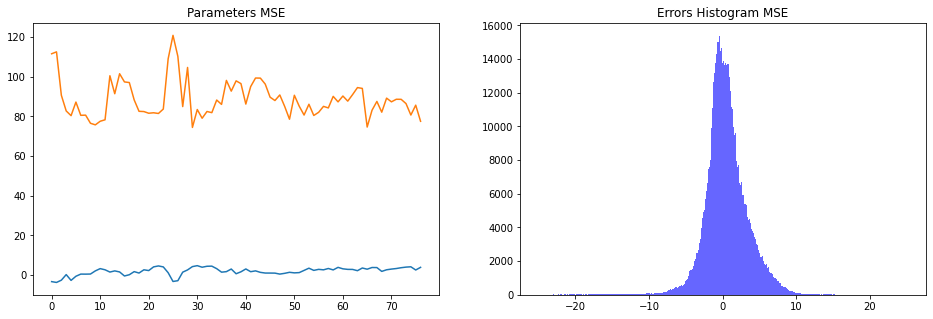

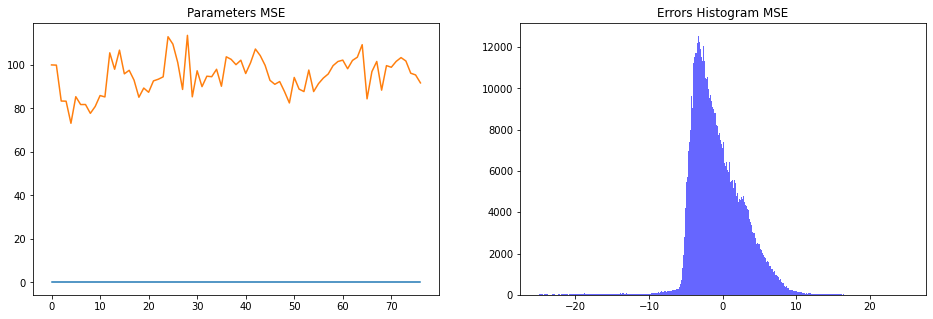

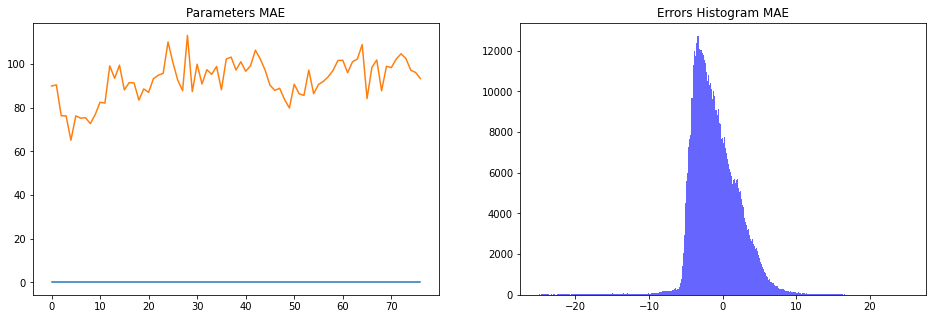

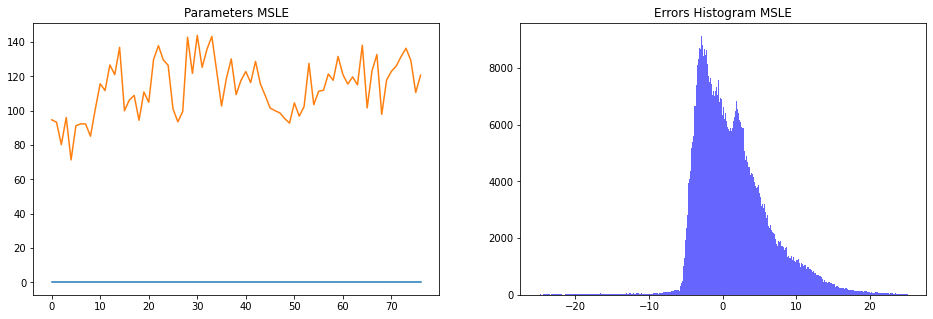

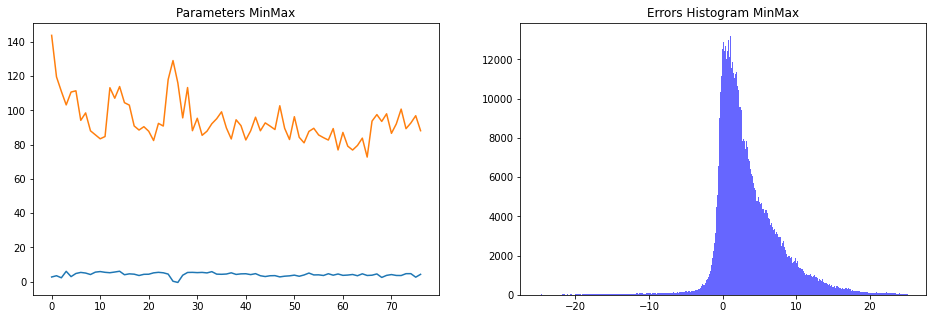

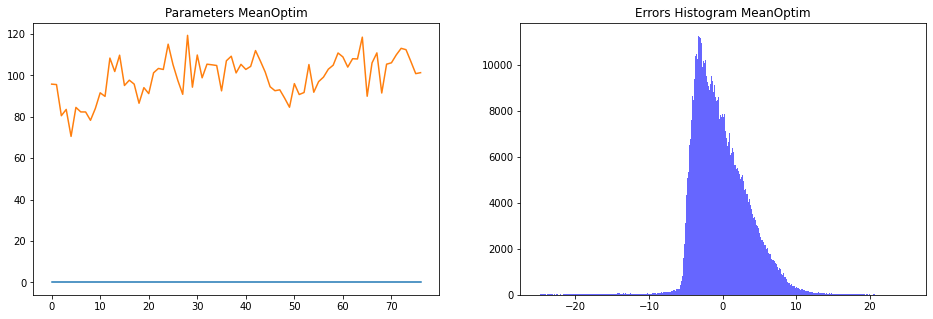

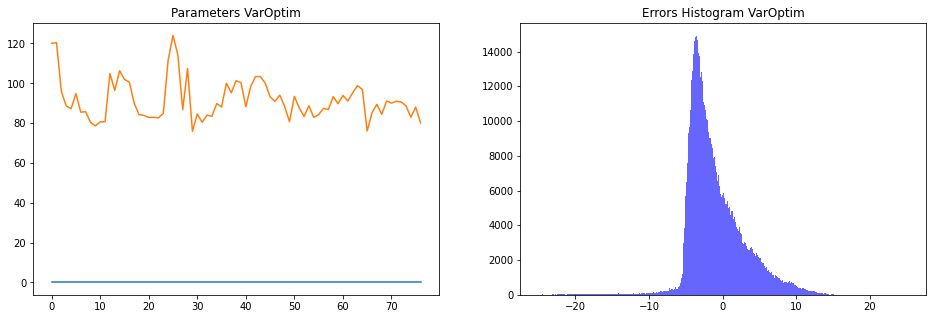

In [573]:
paramss = [
    {"strategy":"MSE", 'bias':True},
    {"strategy":"MSE", 'bias':False},
    {"strategy":"MAE"},
    {"strategy":"MSLE"},
    {"strategy":"MinMax"},
    {"strategy":"MeanOptim"},
    {"strategy":"VarOptim"},
]

images_path = "./processed/depth_02"
lidar_path = "./2011_09_26_drive_0002_sync/velodyne_points/data/"

for params in paramss:
    mses = []
    scales = []
    biases = []
    maxs = []
    errors = []
    for i in tqdm(range(77)):
        img_id = f"{i:010d}"

        img = get_img(os.path.join(images_path, img_id + ".png"))
        cam = get_cam(os.path.join(lidar_path, img_id + ".bin"))
        cam = transfrom_cam(cam, calib)
        cam = np.array(cam)

        train_cam, test_cam = cam_split(cam, params={"IMG_H": img.shape[0], "IMG_W": img.shape[1]})
        # print(img.shape, train_cam.shape)
        model = ScaleEstimator(**params).fit(img, train_cam)

        v_test, u_test, D_test = test_cam
        d_test = img[u_test, v_test, 0]
        D_pred = model.predict(d_test)

        errors.extend(D_pred - D_test)
        mse = mean_squared_error(D_pred, D_test)
        maxs.append(D_test.max())
        mses.append(mse)
        scales.append(model.scale)
        biases.append(model.bias)
    
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(biases, label='Biases')
    plt.plot(scales, label='Scales')
    plt.title(f"Parameters {params['strategy']}")

    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=np.linspace(-25, 25.1, 501), color='b', alpha=0.6)
    plt.title(f"Errors Histogram {params['strategy']}")
    plt.show()